# 数据集

In [1]:
from mnist_reader import load_mnist
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

X_train, y_train = load_mnist('../data/fashion', kind='train')
X_test, y_test = load_mnist('../data/fashion', kind='t10k')

# 查看数据结构
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

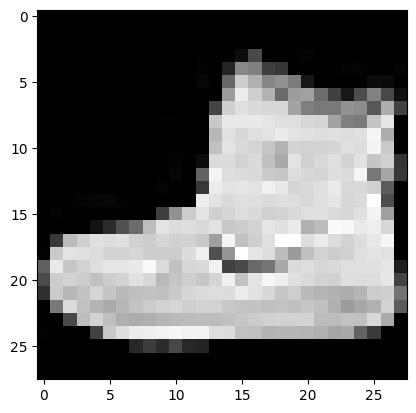

In [2]:
# 可视化第一个样例图片
plt.imshow(X_train[0].reshape(28,28), cmap='gray')
plt.show()

In [3]:
# 每一个种类选一个进行保存
for lable in range(10):
    for idx in range(len(y_train)):
        if np.argmax(y_train[idx]) == lable:
            img = Image.fromarray((X_train[idx].reshape(28,28)*255).astype(np.uint8))
            img.save(f'examples/{lable}.png')

In [4]:
# 进行训练集和验证集的划分
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
len(X_train), len(X_val)

(48000, 12000)

In [5]:
# 查看每个类别的数量
from collections import Counter

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({7: 4841, 3: 4816, 8: 4803, 0: 4798, 4: 4798, 9: 4797, 2: 4795, 5: 4789, 6: 4782, 1: 4781})
Counter({1: 1219, 6: 1218, 5: 1211, 2: 1205, 9: 1203, 4: 1202, 0: 1202, 8: 1197, 3: 1184, 7: 1159})
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


# 网格搜索超参数

In [7]:
import os
from itertools import product

from net import ThreeLayerNN
import mnist_reader
from train import train
from test_vis import test, plot_loss_acc
def grid_search(num_epochs_list, H1_list, H2_list, lambda_list, lr_list, lr_decay_list, data_dir='../data/fashion', weights_dir = 'weights2'):
    os.makedirs(weights_dir, exist_ok=True)
    X_train, y_train = mnist_reader.load_mnist(data_dir, kind='train')
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_test, y_test = mnist_reader.load_mnist(data_dir, kind='t10k')
    for idx, (num_epochs, H1, H2, lambda_, learning_rate, lr_decay) in enumerate(product(num_epochs_list, H1_list, H2_list, lambda_list, lr_list, lr_decay_list)):
        print(f'Experiment {idx + 1}/{len(num_epochs_list) * len(H1_list) * len(H2_list) * len(lambda_list) * len(lr_list) * len(lr_decay_list)}, \
        num_epochs={num_epochs}, H1={H1}, H2={H2}, lambda_={lambda_}, learning_rate={learning_rate}, lr_decay={lr_decay}')
        save_prefix = weights_dir + f'/{idx}idx_{num_epochs}epochs_{H1}H1_{H2}H2_{lambda_}lambda_{learning_rate}lr_{lr_decay}lr_decay'
        model = ThreeLayerNN(784, H1, H2, 10, activation='sigmoid')
        train(model, X_train, y_train, X_val, y_val, lambda_=lambda_, learning_rate=learning_rate, num_epochs=num_epochs, batch_size=512, lr_decay=lr_decay, save_prefix=save_prefix)
        test(model, X_test, y_test, lambda_=lambda_, save_prefix=save_prefix)
        plot_loss_acc(save_prefix)

In [ ]:
num_epochs_list = [100, 200]
H1_list = [50, 100, 150]
H2_list = [50, 100, 150]
lambda_list = [0.001, 0.01, 0.1]
lr_list = [0.0001, 0.001, 0.01]
lr_decay_list = [True, False]

grid_search(num_epochs_list, H1_list, H2_list, lambda_list, lr_list, lr_decay_list, data_dir='../data/fashion', weights_dir = 'weights')

In [9]:
# 统计网格搜索结果
from itertools import product
import pandas as pd
import numpy as np
grid_df = pd.DataFrame([], columns=['num_epochs', 'H1', 'H2', 'lambda_', 'learning_rate', 'lr_decay'])
for idx, (num_epochs, H1, H2, lambda_, learning_rate, lr_decay) in enumerate(product(num_epochs_list, H1_list, H2_list, lambda_list, lr_list, lr_decay_list)):
    # print(f'Experiment {idx + 1}/{len(num_epochs_list) * len(H1_list) * len(H2_list) * len(lambda_list) * len(lr_list) * len(lr_decay_list)}, \
    # num_epochs={num_epochs}, H1={H1}, H2={H2}, lambda_={lambda_}, learning_rate={learning_rate}, lr_decay={lr_decay}')
    try :
        save_prefix = f'weights/{idx}idx_{num_epochs}epochs_{H1}H1_{H2}H2_{lambda_}lambda_{learning_rate}lr_{lr_decay}lr_decay'
        npzfile = np.load(save_prefix+'_loss_acc.npz')
        loss_val_arr = npzfile['loss_val_arr']
        acc_val_arr = npzfile['acc_val_arr']
        grid_df = pd.concat([grid_df, pd.DataFrame({'num_epochs': num_epochs, 'H1': H1, 'H2': H2, 'lambda_': lambda_, 'learning_rate': learning_rate, 'lr_decay': lr_decay, 'loss_val': loss_val_arr[-1], 'acc_val': acc_val_arr[-1]}, index=[idx])], axis=0)
    except:
        continue
print(len(grid_df))
# 保存结果
grid_df.sort_values(by='acc_val', ascending=False).to_csv('grid_search_results.csv', index=False)
# 查看最好的15个结果
grid_df.sort_values(by='acc_val', ascending=False).head(15)

324


,num_epochs,H1,H2,lambda_,learning_rate,lr_decay,loss_val,acc_val
227,200,100,50,0.01,0.010,False,0.042734,0.887333
248,200,100,100,0.10,0.001,True,0.050882,0.887167
298,200,150,100,0.01,0.010,True,0.039804,0.885917
284,200,150,50,0.10,0.001,True,0.068056,0.884667
321,200,150,150,0.10,0.001,False,0.045693,0.884667
299,200,150,100,0.01,0.010,False,0.039530,0.883750
267,200,100,150,0.10,0.001,False,0.046299,0.883583
230,200,100,50,0.10,0.001,True,0.071250,0.883083
208,200,50,150,0.01,0.010,True,0.037623,0.883000
231,200,100,50,0.10,0.001,False,0.070160,0.882500


# 正则化强度超参数搜索

In [ ]:
num_epochs_list = [300]
H1_list = [150]
H2_list = [150]
lambda_list = [0.005, 0.01, 0.02,0.05, 0.1, 0.2]
lr_list = [0.002]
lr_decay_list = [True]

grid_search(num_epochs_list, H1_list, H2_list, lambda_list, lr_list, lr_decay_list, data_dir='../data/fashion', weights_dir = 'weights2')


In [11]:
# 统计正则化强度超参数搜索结果
from itertools import product
import pandas as pd
import numpy as np

import mnist_reader
from net import ThreeLayerNN
from test_vis import test


X_test, y_test = mnist_reader.load_mnist('../data/fashion', kind='t10k')
lambda_result_df = pd.DataFrame([], columns=['lambda_', 'loss_train', 'acc_train', 'loss_val', 'acc_val', 'loss_test', 'acc_test'])
grid_df2 = pd.DataFrame([], columns=['num_epochs', 'H1', 'H2', 'lambda_', 'learning_rate', 'lr_decay'])
for idx, (num_epochs, H1, H2, lambda_, learning_rate, lr_decay) in enumerate(product(num_epochs_list, H1_list, H2_list, lambda_list, lr_list, lr_decay_list)):
    # print(f'Experiment {idx + 1}/{len(num_epochs_list) * len(H1_list) * len(H2_list) * len(lambda_list) * len(lr_list) * len(lr_decay_list)}, \
    # num_epochs={num_epochs}, H1={H1}, H2={H2}, lambda_={lambda_}, learning_rate={learning_rate}, lr_decay={lr_decay}')
    # try :
    save_prefix = f'weights2/{idx}idx_{num_epochs}epochs_{H1}H1_{H2}H2_{lambda_}lambda_{learning_rate}lr_{lr_decay}lr_decay'
    npzfile = np.load(save_prefix+'_loss_acc.npz')
    loss_train_arr = npzfile['loss_train_arr']
    acc_train_arr = npzfile['acc_train_arr']
    loss_val_arr = npzfile['loss_val_arr']
    acc_val_arr = npzfile['acc_val_arr']
    position = np.argmax(acc_val_arr)
    model = ThreeLayerNN(784, 150, 150, 10, activation='sigmoid')
    loss_test, acc_test = test(model, X_test, y_test, lambda_=0.05, save_prefix=save_prefix)
    lambda_result_df = pd.concat([lambda_result_df, pd.DataFrame({'lambda_': lambda_, 'loss_train': loss_train_arr[position], 'acc_train': acc_train_arr[position], 'loss_val': loss_val_arr[position], 'acc_val': acc_val_arr[position], 'loss_test': loss_test, 'acc_test': acc_test}, index=[idx])], axis=0)
    grid_df2 = pd.concat([grid_df2, pd.DataFrame({'num_epochs': num_epochs, 'H1': H1, 'H2': H2, 'lambda_': lambda_, 'learning_rate': learning_rate, 'lr_decay': lr_decay, 'loss_val': loss_val_arr[-1], 'acc_val': acc_val_arr[-1]}, index=[idx])], axis=0)
    # print(idx)
    # except:
    #     continue
grid_df2.sort_values(by='acc_val', ascending=False).head(10)

Test loss: 0.1213, Test accuracy: 0.8545
Test loss: 0.0946, Test accuracy: 0.8717
Test loss: 0.0633, Test accuracy: 0.8793
Test loss: 0.0407, Test accuracy: 0.8897
Test loss: 0.0385, Test accuracy: 0.8781
Test loss: 0.0399, Test accuracy: 0.8690


,num_epochs,H1,H2,lambda_,learning_rate,lr_decay,loss_val,acc_val
3,300,150,150,0.050,0.002,True,0.037701,0.895250
2,300,150,150,0.020,0.002,True,0.045285,0.884833
1,300,150,150,0.010,0.002,True,0.054374,0.877333
5,300,150,150,0.200,0.002,True,0.050637,0.867167
0,300,150,150,0.005,0.002,True,0.066020,0.855167
4,300,150,150,0.100,0.002,True,0.058772,0.837583


In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(lambda_result_df['loss_train'], label='train')
plt.plot(lambda_result_df['loss_val'], label='val')
plt.plot(lambda_result_df['loss_test'], label='test')
plt.xticks(range(6), [0.005, 0.01, 0.02,0.05, 0.1, 0.2])
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(lambda_result_df['acc_train'], label='train')
plt.plot(lambda_result_df['acc_val'], label='val')
plt.plot(lambda_result_df['acc_test'], label='test')
plt.xticks(range(6), [0.005, 0.01, 0.02,0.05, 0.1, 0.2])
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.savefig('vis/lambda_loss_acc.png')
plt.close()

# 在测试集上运行最好的模型

In [1]:
# 加载最优模型
import numpy as np
import matplotlib.pyplot as plt

from net import ThreeLayerNN
from mnist_reader import load_mnist
from test_vis import test

X_test, y_test = load_mnist('../data/fashion', kind='t10k')
path_prefix = 'best_model/3idx_300epochs_150H1_150H2_0.05lambda_0.002lr_Truelr_decay'
model = ThreeLayerNN(784, 150, 150, 10, activation='sigmoid')
test(model, X_test, y_test, lambda_=0.05, save_prefix=path_prefix)
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(model.W1[:-1,i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.savefig('vis/best_model_W1.png')
plt.close()

Test loss: 0.0407, Test accuracy: 0.8897


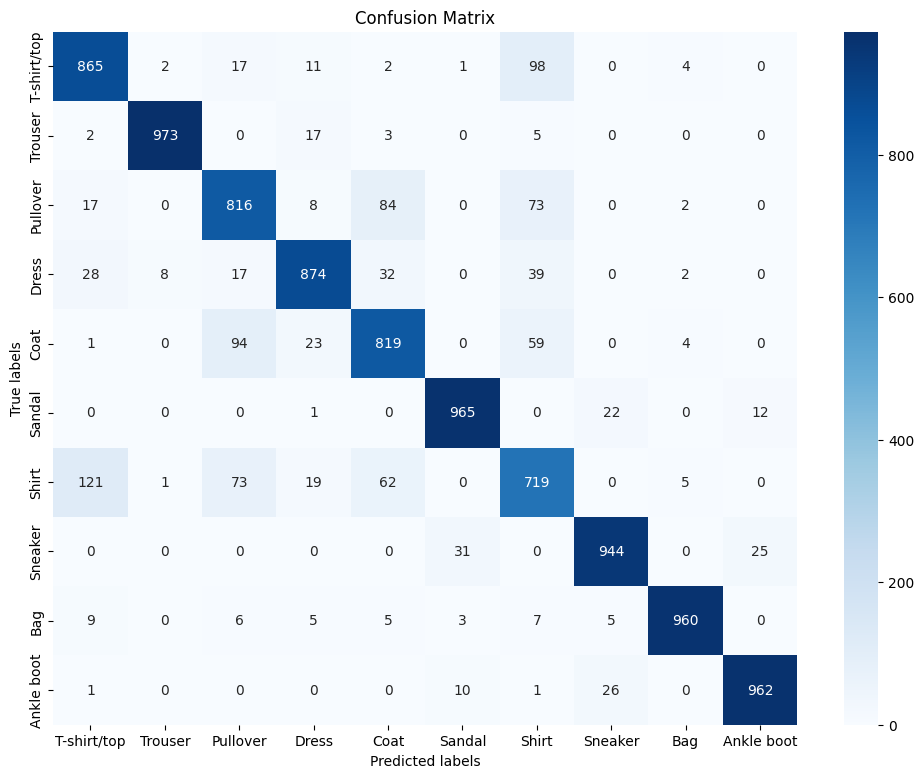

In [2]:
# 绘制混淆矩阵
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


model.load(f'{path_prefix}_best_model.npz')
y_pred_test = model.forward(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_test, axis=1)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
class_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# 可视化混淆矩阵
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('vis/Confusion Matrix.png')
plt.show()
plt.close()
